In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import copy
from functools import partial

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
from metal.utils import convert_labels, split_data
from metal.mmtl.metal_model import MetalModel
from metal.mmtl.slicing.slice_model import SliceModel, SliceModelRep
from metal.mmtl.slicing.moe_model import MoEModel

from metal.mmtl.trainer import MultitaskTrainer
from metal.mmtl.slicing.synthetics.mmtl_utils import create_tasks, create_payloads, train_slice_experts
from metal.mmtl.slicing.synthetics.data_generator import generate_data, get_circle_mask
from metal.mmtl.slicing.synthetics.viz import visualize_payload, visualize_predictions, visualize_attention, score_and_visualize

In [5]:
from metal.utils import set_seed

seed = 444
set_seed(seed)

### Generate Synthetic Dataset
We aim to build a dataset with a linear decision boundary and an abnormal boundary around $x=0.25, y=0$.
We define this slice as our `critical_region`.

In [6]:
def generate_data(N, label_flips):
    """ Generates data in numpy form.

    Returns: (
        [uids_train, uids_val, uids_test],
        [X_train, X_val, X_test],
        [Y_train, Y_val, Y_test]
    )
    """

    uids = list(range(N))
    X = np.random.random((N, 2)) * 2 - 1
    Y = (X[:, 0] > X[:, 1] + 0.25).astype(int) + 1

    # abberation in decision boundary
    for mask_fn, label in label_flips.items():
        Y[mask_fn(X)] = label

    uid_lists, Xs, Ys = split_data(uids, X, Y, splits=[0.5, 0.25, 0.25], shuffle=True)
    return uid_lists, Xs, Ys

In [7]:
from functools import partial
flip_1 = partial(get_circle_mask, center=(0.25, 0), radius=0.02)
flip_2 = partial(get_circle_mask, center=(-0.3, -0.5), radius=0.015)

label_flips = {
    flip_1: 1,
    flip_2: 2
}
uid_lists, Xs, Ys = generate_data(N=500, label_flips=label_flips)
task_name = "test_task"

#### Generate eval payload over the `critical_slice`

In [8]:
# targets all the data -- used to add the BASE labelset to payloads
identity_fn = lambda x: np.ones(x.shape[0], dtype=np.bool)
# NOTE: the slice function _imperfectly_ targets the critical slice area.
slice_1 = partial(get_circle_mask, center=(0.35, -0.1), radius=0.2)
slice_2 = partial(get_circle_mask, center=(-0.35, -0.4), radius=0.15)

remainder = lambda X: np.logical_not(np.logical_or(slice_1(X), slice_2(X)))

In [9]:
eval_payload = create_payloads(task_name, uid_lists, Xs, Ys, batch_size=1000, 
   slice_funcs={"slice_1": slice_1, "slice_2": slice_2, "remainder": remainder}
#    slice_funcs={"slice_1": flip_1, "slice_2": flip_2}
)[2] # take test set

Vizualizing labelset_gold from payload_test


/dfs/scratch0/vschen/venv-mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


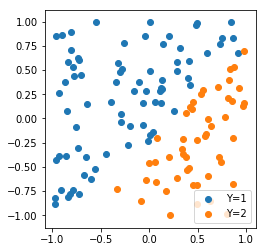

Vizualizing labelset:slice_1:pred from payload_test


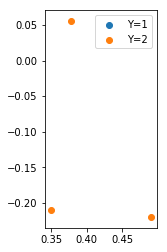

Vizualizing labelset:slice_1:ind from payload_test


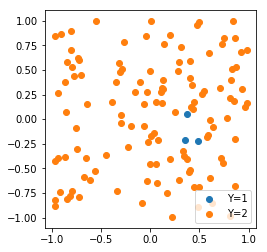

Vizualizing labelset:slice_2:pred from payload_test


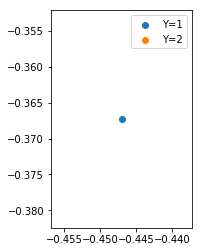

Vizualizing labelset:slice_2:ind from payload_test


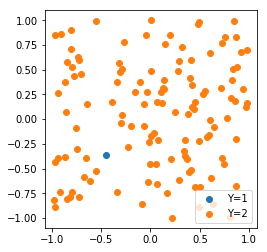

Vizualizing labelset:remainder:pred from payload_test


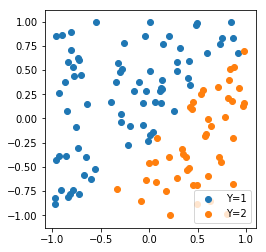

Vizualizing labelset:remainder:ind from payload_test


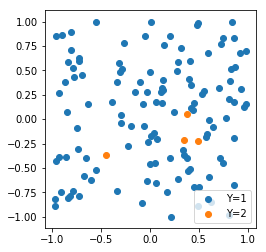

In [10]:
visualize_payload(eval_payload)

### Initialize and train each model type

In [11]:
# all models to test to test
all_slice_funcs = {"slice_1": slice_1, "slice_2": slice_2, "BASE": identity_fn}
slice_loss_multiplier = 1.0 / (2*len(all_slice_funcs))

model_configs = {

    'soft_param-rep': {
        'slice_funcs': all_slice_funcs,
        'create_ind': True,
        'create_preds': False,
        'model_class': SliceModelRep,
        'slice_weights': {
            'BASE': slice_loss_multiplier,
            'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
        }
    }
}

    'soft_param': {
        'slice_funcs': all_slice_funcs,
        'create_ind': True,
        'model_class': SliceModel,
        'slice_weights': {
            'BASE': slice_loss_multiplier,
            'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
        }
    },
    'naive': {
        'slice_funcs': {},
        'model_class': MetalModel   
    },

In [12]:
train_kwargs = {
    "lr": 0.01, 
    "n_epochs": 3,
    "checkpoint_best": False,
    "log_every": 5.0,
    "writer": "tensorboard", 
    "verbose": False,
    "progress_bar": False
}

In [14]:
%%time
trained_models = {}
for model_name, config in model_configs.items():
    print(f"{'='*10}Initializing + Training {model_name}{'='*10}")
    slice_funcs = config['slice_funcs']
    model_class = config['model_class']
    slice_weights = config.get("slice_weights", {})
    create_ind = config.get("create_ind", True)
    create_preds = config.get("create_preds", True)
          
    tasks = create_tasks(
        task_name, 
        slice_names=list(slice_funcs.keys()), 
        slice_weights=slice_weights, 
        create_ind=create_ind,
        create_preds=create_preds,
        verbose=True
    )
    payloads = create_payloads(
        task_name, 
        uid_lists, 
        Xs, 
        Ys, 
        batch_size=16, 
        slice_funcs=slice_funcs, 
        create_ind=create_ind,
        create_preds=create_preds,
        verbose=True
    )
    # visualize_payload(payloads[0])
          
    model = model_class(tasks, verbose=False, seed=seed)
    trainer = MultitaskTrainer(seed=seed)
    metrics_dict = trainer.train_model(model, payloads, **train_kwargs)
    print(metrics_dict) 
    trained_models[model_name] = model

==========Initializing + Training soft_param-rep==========
Creating 4 tasks...
BinaryClassificationTask(name=test_task, loss_multiplier=1.00, slice_head_type=None)
BinaryClassificationTask(name=test_task:slice_1:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task:slice_2:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task:BASE:ind, loss_multiplier=0.17, slice_head_type=ind)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:slice_1:ind': 'test_task:slice_1:ind', 'labelset:slice_2:ind': 'test_task:slice_2:ind', 'labelset:BASE:ind': 'test_task:BASE:ind'}], split=train)
Payload(payload_valid: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:slice_1:ind': 'test_task:slice_1:ind', 'labelset:slice_2:ind': 'test_task:slice_2:ind', 'labelset:BASE:ind': 'test_task:BASE:ind'}], split=valid)
Payload(payload_test: labels_to_tasks=[{'labelset_gold': 'test_task', 'lab

/dfs/scratch0/chami/metal/metal/mmtl/trainer.py:915: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


Cleaning checkpoints
Full model saved at /dfs/scratch0/chami/metal/logs/2019_05_01/17_01_51/model.pkl
{'test_task/payload_test/labelset_gold/accuracy': 0.608, 'test_task:slice_1:ind/payload_test/labelset:slice_1:ind/accuracy': 0.976, 'test_task:slice_2:ind/payload_test/labelset:slice_2:ind/accuracy': 0.992, 'test_task:BASE:ind/payload_test/labelset:BASE:ind/accuracy': 1.0}
CPU times: user 4.76 s, sys: 928 ms, total: 5.69 s
Wall time: 6.57 s
